## Importing Libraries

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import requests
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
import re
import string

## Data Extraction From MyAnimeList API

In [ ]:
#setting up credentials parameters for API call
endpoint = 'https://api.myanimelist.net/v2/anime/ranking'
params = {'ranking_type':'all',
          'fields': "id,title,alternative_titles,rank,num_episodes,source,num_scoring_users,genres,media_type,status,num_episodes,source,studios,popularity"}
client_id = 'YOUR CLIENT ID'
headers = {'X-MAL-CLIENT-ID': client_id}
limit=500
offset=0

anime_data=[] # list to store the data

#accessing data throung top anime list till no titles are available
try:
    while True:
        params['limit'] = limit
        params['offset'] = offset
        ranking_response = requests.get(endpoint, params=params, headers=headers) #API call
        ranking_response.raise_for_status() # Check for errors
        ranking_data_batch = ranking_response.json()['data'] #Parsing the data and storing in temp object
        if not ranking_data_batch: #check to see if we reached the end of list
            break
        anime_data += ranking_data_batch # adding into the main list
        offset += limit
except requests.exceptions.RequestException as e: #exception handling
    print(f'Error fetching data from API: {e}')

# Print the total number of anime entries fetched
print(f'Total anime entries fetched: {len(anime_data)}')

Total anime entries fetched: 24607


In [ ]:
#Printing a single data node to know the structure of data
anime_data[9]

{'node': {'id': 11061,
  'title': 'Hunter x Hunter (2011)',
  'main_picture': {'medium': 'https://cdn.myanimelist.net/images/anime/1337/99013.jpg',
   'large': 'https://cdn.myanimelist.net/images/anime/1337/99013l.jpg'},
  'alternative_titles': {'synonyms': ['HxH (2011)'],
   'en': 'Hunter x Hunter',
   'ja': 'HUNTER×HUNTER（ハンター×ハンター）'},
  'rank': 10,
  'num_episodes': 148,
  'source': 'manga',
  'num_scoring_users': 1647641,
  'genres': [{'id': 1, 'name': 'Action'},
   {'id': 2, 'name': 'Adventure'},
   {'id': 10, 'name': 'Fantasy'},
   {'id': 27, 'name': 'Shounen'}],
  'media_type': 'tv',
  'status': 'finished_airing',
  'studios': [{'id': 11, 'name': 'Madhouse'}],
  'popularity': 10},
 'ranking': {'rank': 10}}

### Transforming The Data Into DataFrame

In [ ]:
anime_list = []
for anime in anime_data:
    anime_dict = {'id': anime['node']['id'],
                  'title': anime['node']['title'],
                  'alternative_titles':anime['node'].get('alternative_titles',{}).get('en'),
                  'img': anime['node'].get('main_picture',{}).get('medium'),
                  'num_episodes':anime['node']['num_episodes'],
                  'source': anime['node'].get('source',None),
                  'num_users': anime['node']['num_scoring_users'],
                  'genres': [genre['name'] for genre in anime['node'].get('genres',[])],
                  'media_type': anime['node']['media_type'],
                  'status': anime['node']['status'],
                  'num_episodes': anime['node']['num_episodes'],
                  'studios': anime['node']['studios'][0].get('name') if anime['node'].get('studios') else None,
                  'popularity': anime['node']['popularity'],
                  'rank':anime['ranking'].get('rank')
                 }
    anime_list.append(anime_dict)

# create a DataFrame from the list of dictionaries
anime_df = pd.DataFrame(anime_list)

#converting all string into lowercase
anime_df = anime_df.applymap(lambda x:x.lower() if isinstance(x,str) else x)

#saving data in local storage in csv file
anime_df.to_csv('anime.csv',index=False)

## Data cleaning

### Data shapes and info

In [ ]:
anime_df = pd.read_csv('anime.csv')
anime_df.head()

,id,title,alternative_titles,img,num_episodes,source,num_users,genres,media_type,status,studios,popularity,rank
0,5114,fullmetal alchemist: brotherhood,fullmetal alchemist: brotherhood,https://cdn.myanimelist.net/images/anime/1208/...,64,manga,2016286,"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...",tv,finished_airing,bones,3,1
1,41467,bleach: sennen kessen-hen,bleach: thousand-year blood war,https://cdn.myanimelist.net/images/anime/1956/...,13,manga,210895,"['Action', 'Adventure', 'Fantasy', 'Shounen']",tv,finished_airing,pierrot,470,2
2,9253,steins;gate,steins;gate,https://cdn.myanimelist.net/images/anime/1935/...,24,visual_novel,1333778,"['Drama', 'Psychological', 'Sci-Fi', 'Suspense...",tv,finished_airing,white fox,13,3
3,38524,shingeki no kyojin season 3 part 2,attack on titan season 3 part 2,https://cdn.myanimelist.net/images/anime/1517/...,10,manga,1467781,"['Action', 'Drama', 'Gore', 'Military', 'Shoun...",tv,finished_airing,wit studio,24,4
4,51535,shingeki no kyojin: the final season - kankets...,attack on titan: the final season - final chap...,https://cdn.myanimelist.net/images/anime/1279/...,2,manga,152122,"['Action', 'Drama', 'Gore', 'Military', 'Shoun...",special,currently_airing,mappa,487,5


In [ ]:
print(f"anime set (row, col): {anime_df.shape}")

anime set (row, col): (24607, 13)


In [ ]:
print("Anime:")
print(anime_df.info())

Anime:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24607 entries, 0 to 24606
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  24607 non-null  int64 
 1   title               24607 non-null  object
 2   alternative_titles  10188 non-null  object
 3   img                 24452 non-null  object
 4   num_episodes        24607 non-null  int64 
 5   source              20930 non-null  object
 6   num_users           24607 non-null  int64 
 7   genres              24607 non-null  object
 8   media_type          24607 non-null  object
 9   status              24607 non-null  object
 10  studios             14321 non-null  object
 11  popularity          24607 non-null  int64 
 12  rank                24607 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 2.4+ MB
None


In [ ]:
print("Anime missing values (%):")
print(round(anime_df.isnull().sum().sort_values(ascending=False)/len(anime_df.index),4)*100)

Anime missing values (%):
alternative_titles    58.60
studios               41.80
source                14.94
img                    0.63
id                     0.00
title                  0.00
num_episodes           0.00
num_users              0.00
genres                 0.00
media_type             0.00
status                 0.00
popularity             0.00
rank                   0.00
dtype: float64


In [ ]:
print(f"Summary of The Anime Dataset :")
anime_df.describe()

Summary of The Anime Dataset :


,id,num_episodes,num_users,popularity,rank
count,24607.000000,24607.000000,2.460700e+04,24607.000000,24607.000000
mean,29469.482302,14.675418,1.907007e+04,12304.000000,12304.000000
std,17864.693601,48.282819,9.426605e+04,7103.573373,7103.573373
min,1.000000,0.000000,0.000000e+00,1.000000,1.000000
25%,10344.000000,1.000000,4.800000e+01,6152.500000,6152.500000
50%,34342.000000,2.000000,3.040000e+02,12304.000000,12304.000000
75%,44906.500000,13.000000,3.436000e+03,18455.500000,18455.500000
max,55595.000000,3057.000000,2.655870e+06,24607.000000,24607.000000


In [ ]:
anime_df.describe(include=object)

,title,alternative_titles,img,source,genres,media_type,status,studios
count,24607,10188,24452,20930,24607,24607,24607,14321
unique,24607,9997,24452,16,5374,7,3,951
top,fullmetal alchemist: brotherhood,spirit guardians,https://cdn.myanimelist.net/images/anime/1208/...,original,['Kids'],tv,finished_airing,toei animation
freq,1,5,1,9461,1616,7578,23818,856


### Handling missing values

In [ ]:
print("Null Values of Anime Dataset :")
anime_df.isna().sum().to_frame()

Null Values of Anime Dataset :


,0
id,0
title,0
alternative_titles,14419
img,155
num_episodes,0
source,3677
num_users,0
genres,0
media_type,0
status,0


In [ ]:
#removing row that don't have studio name present
anime_df = anime_df[anime_df['studios'].notna()]
anime_df.shape

(14321, 13)

In [ ]:
print("Null Values of Anime Dataset :")
anime_df.isna().sum().to_frame()

Null Values of Anime Dataset :


,0
id,0
title,0
alternative_titles,7092
img,12
num_episodes,0
source,1478
num_users,0
genres,0
media_type,0
status,0


In [ ]:
#count of each source
anime_df.groupby(['source']).size()

source
4_koma_manga     277
book             104
card_game         61
game             866
light_novel      910
manga           4134
mixed_media       98
music            103
novel            580
original        3688
other            468
picture_book     104
radio              7
visual_novel    1052
web_manga        343
web_novel         48
dtype: int64

In [ ]:
#Replacing nan values in source column with unknown
anime_df['source'].fillna('unknown',inplace=True)
print(anime_df.groupby(['source']).size())
anime_df.describe(include='all')

source
4_koma_manga     277
book             104
card_game         61
game             866
light_novel      910
manga           4134
mixed_media       98
music            103
novel            580
original        3688
other            468
picture_book     104
radio              7
unknown         1478
visual_novel    1052
web_manga        343
web_novel         48
dtype: int64


,id,title,alternative_titles,img,num_episodes,source,num_users,genres,media_type,status,studios,popularity,rank
count,14321.000000,14321,7229,14309,14321.000000,14321,1.432100e+04,14321,14321,14321,14321,14321.000000,14321.000000
unique,NaN,14321,7102,14309,NaN,17,NaN,4623,7,3,951,NaN,NaN
top,NaN,fullmetal alchemist: brotherhood,spirit guardians,https://cdn.myanimelist.net/images/anime/1208/...,NaN,manga,NaN,['Hentai'],tv,finished_airing,toei animation,NaN,NaN
freq,NaN,1,4,1,NaN,4134,NaN,971,4871,13808,856,NaN,NaN
mean,23275.142937,NaN,NaN,NaN,12.336988,NaN,3.259079e+04,NaN,NaN,NaN,NaN,8177.606801,9479.574471
std,17932.337522,NaN,NaN,NaN,38.337222,NaN,1.217818e+05,NaN,NaN,NaN,NaN,5598.263150,7330.167920
min,1.000000,NaN,NaN,NaN,0.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,1.000000,1.000000
25%,4820.000000,NaN,NaN,NaN,1.000000,NaN,3.190000e+02,NaN,NaN,NaN,NaN,3606.000000,3624.000000
50%,22763.000000,NaN,NaN,NaN,3.000000,NaN,2.119000e+03,NaN,NaN,NaN,NaN,7353.000000,7444.000000
75%,38648.000000,NaN,NaN,NaN,12.000000,NaN,1.320900e+04,NaN,NaN,NaN,NaN,11733.000000,14172.000000


In [ ]:
anime_df.describe()

,id,num_episodes,num_users,popularity,rank
count,14321.000000,14321.000000,1.432100e+04,14321.000000,14321.000000
mean,23275.142937,12.336988,3.259079e+04,8177.606801,9479.574471
std,17932.337522,38.337222,1.217818e+05,5598.263150,7330.167920
min,1.000000,0.000000,0.000000e+00,1.000000,1.000000
25%,4820.000000,1.000000,3.190000e+02,3606.000000,3624.000000
50%,22763.000000,3.000000,2.119000e+03,7353.000000,7444.000000
75%,38648.000000,12.000000,1.320900e+04,11733.000000,14172.000000
max,55571.000000,1818.000000,2.655870e+06,24597.000000,24606.000000


In [ ]:
#creating copy with selected fields that would be useful for further use
anime = anime_df[['id','title','rank','num_episodes','num_users','genres','media_type','status','source','studios','popularity','img']].copy()
anime.head(2)

,id,title,rank,num_episodes,num_users,genres,media_type,status,source,studios,popularity,img
0,5114,fullmetal alchemist: brotherhood,1,64,2016286,"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...",tv,finished_airing,manga,bones,3,https://cdn.myanimelist.net/images/anime/1208/...
1,41467,bleach: sennen kessen-hen,2,13,210895,"['Action', 'Adventure', 'Fantasy', 'Shounen']",tv,finished_airing,manga,pierrot,470,https://cdn.myanimelist.net/images/anime/1956/...


## EDA

In [ ]:
#importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

In [ ]:
# Split the comma-separated genres string into a list of genres
anime['genres'] = anime['genres'].apply(lambda x: x.strip('[]').replace("'", "").split(', '))

# Flatten the genres into a single list
all_genres = [genre for genres in anime['genres'] for genre in genres]

# Count the number of anime for each genre
genre_counts = pd.Series(all_genres).value_counts().to_dict()

# Create a pandas DataFrame from the genre counts
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])

# Sort the genres by count
genre_counts_df = genre_counts_df.sort_values(by='Count', ascending=False)

# Reset index and rename columns
genre_counts_df = genre_counts_df.reset_index().rename(columns={'index': 'Genre'})

genre_counts_df


,Genre,Count
0,Comedy,5118
1,Action,3906
2,Fantasy,3229
3,Adventure,2688
4,Sci-Fi,2437
...,...,...
72,High Stakes Game,38
73,Medical,33
74,Showbiz,33
75,Crossdressing,30


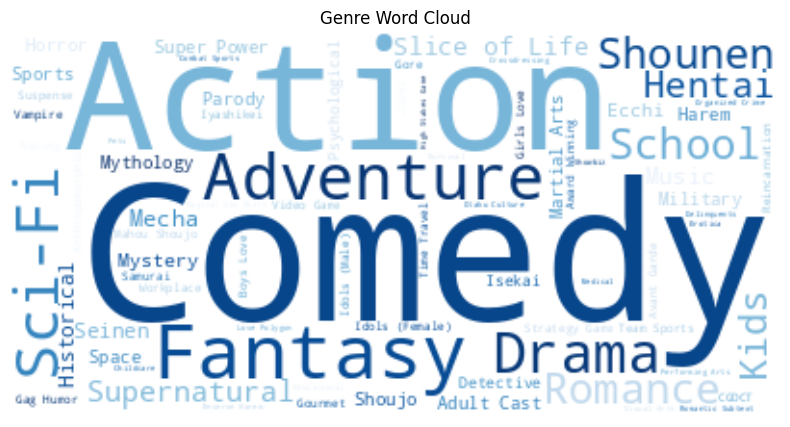

In [ ]:
# Convert DataFrame to dictionary
genre_dict = genre_counts_df.set_index('Genre')['Count'].to_dict()

# Generate the word cloud
wordcloud = WordCloud(background_color='white',colormap='Blues').generate_from_frequencies(genre_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Genre Word Cloud')

plt.show()

In [ ]:
# Create a DataFrame with media type and count
media_type_df = anime['media_type'].value_counts().reset_index()
media_type_df.columns = ['MediaType', 'Count']
media_type_df

,MediaType,Count
0,tv,4871
1,ova,3096
2,movie,2250
3,special,1860
4,ona,1738
5,music,493
6,unknown,13


In [ ]:
# Create the interactive bar chart using Plotly Express
fig = px.bar(media_type_df, x='Count', y='MediaType', orientation='h', color='Count',
             color_continuous_scale='Blues')

# Set the axis labels and title
fig.update_layout(xaxis_title='Count', yaxis_title='MediaType',
                  title='Count of Anime Titles by Media Type')

# Show the plot
fig.show()

In [ ]:
# removing titles other than TV anime series
anime = anime[anime['media_type']=='tv']
anime

,id,title,rank,num_episodes,num_users,genres,media_type,status,source,studios,popularity,img
0,5114,fullmetal alchemist: brotherhood,1,64,2016286,"[Action, Adventure, Drama, Fantasy, Military, ...",tv,finished_airing,manga,bones,3,https://cdn.myanimelist.net/images/anime/1208/...
1,41467,bleach: sennen kessen-hen,2,13,210895,"[Action, Adventure, Fantasy, Shounen]",tv,finished_airing,manga,pierrot,470,https://cdn.myanimelist.net/images/anime/1956/...
2,9253,steins;gate,3,24,1333778,"[Drama, Psychological, Sci-Fi, Suspense, Time ...",tv,finished_airing,visual_novel,white fox,13,https://cdn.myanimelist.net/images/anime/1935/...
3,38524,shingeki no kyojin season 3 part 2,4,10,1467781,"[Action, Drama, Gore, Military, Shounen, Survi...",tv,finished_airing,manga,wit studio,24,https://cdn.myanimelist.net/images/anime/1517/...
5,28977,gintama°,6,51,237393,"[Action, Comedy, Gag Humor, Historical, Parody...",tv,finished_airing,manga,bandai namco pictures,332,https://cdn.myanimelist.net/images/anime/3/720...
...,...,...,...,...,...,...,...,...,...,...,...,...
23040,53887,spy x family season 2,23041,0,7,"[Action, Childcare, Comedy, Shounen]",tv,not_yet_aired,manga,wit studio,1530,https://cdn.myanimelist.net/images/anime/1573/...
23049,54842,sugar apple fairy tale part 2,23050,0,0,"[Adventure, Fantasy, Romance, Shoujo, Visual A...",tv,not_yet_aired,light_novel,j.c.staff,4946,https://cdn.myanimelist.net/images/anime/1399/...
23056,54234,suki na ko ga megane wo wasureta,23057,0,2,"[Comedy, Romantic Subtext, School, Shounen]",tv,not_yet_aired,manga,gohands,3091,https://cdn.myanimelist.net/images/anime/1582/...
23656,40750,kaifuku jutsushi no yarinaoshi,23657,12,314733,"[Adventure, Drama, Erotica, Fantasy, Harem, Ti...",tv,finished_airing,light_novel,tnk,365,https://cdn.myanimelist.net/images/anime/1301/...


In [ ]:
anime = anime.explode('genres')
anime

,id,title,rank,num_episodes,num_users,genres,media_type,status,source,studios,popularity,img
0,5114,fullmetal alchemist: brotherhood,1,64,2016286,Action,tv,finished_airing,manga,bones,3,https://cdn.myanimelist.net/images/anime/1208/...
0,5114,fullmetal alchemist: brotherhood,1,64,2016286,Adventure,tv,finished_airing,manga,bones,3,https://cdn.myanimelist.net/images/anime/1208/...
0,5114,fullmetal alchemist: brotherhood,1,64,2016286,Drama,tv,finished_airing,manga,bones,3,https://cdn.myanimelist.net/images/anime/1208/...
0,5114,fullmetal alchemist: brotherhood,1,64,2016286,Fantasy,tv,finished_airing,manga,bones,3,https://cdn.myanimelist.net/images/anime/1208/...
0,5114,fullmetal alchemist: brotherhood,1,64,2016286,Military,tv,finished_airing,manga,bones,3,https://cdn.myanimelist.net/images/anime/1208/...
...,...,...,...,...,...,...,...,...,...,...,...,...
23656,40750,kaifuku jutsushi no yarinaoshi,23657,12,314733,Time Travel,tv,finished_airing,light_novel,tnk,365,https://cdn.myanimelist.net/images/anime/1301/...
23877,8861,"yosuga no sora: in solitude, where we are leas...",23878,12,255367,Drama,tv,finished_airing,visual_novel,feel.,427,https://cdn.myanimelist.net/images/anime/5/762...
23877,8861,"yosuga no sora: in solitude, where we are leas...",23878,12,255367,Erotica,tv,finished_airing,visual_novel,feel.,427,https://cdn.myanimelist.net/images/anime/5/762...
23877,8861,"yosuga no sora: in solitude, where we are leas...",23878,12,255367,Harem,tv,finished_airing,visual_novel,feel.,427,https://cdn.myanimelist.net/images/anime/5/762...


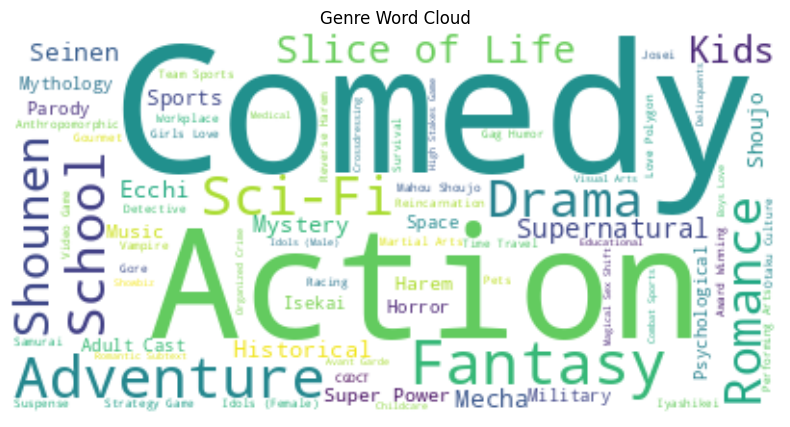

In [ ]:
# Count the number of anime for each genre
genre_counts = pd.Series(anime['genres']).value_counts().to_dict()

# Create a pandas DataFrame from the genre counts
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])

# Sort the genres by count
genre_counts_df = genre_counts_df.sort_values(by='Count', ascending=False)

# Reset index and rename columns
genre_counts_df = genre_counts_df.reset_index().rename(columns={'index': 'Genre'})

# Convert DataFrame to dictionary
genre_dict = genre_counts_df.set_index('Genre')['Count'].to_dict()

# Generate the word cloud
wordcloud = WordCloud(background_color='white').generate_from_frequencies(genre_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Genre Word Cloud')

plt.show()


In [ ]:
genre_counts_df.head()

,Genre,Count
0,Comedy,2149
1,Action,1546
2,Fantasy,1218
3,Adventure,1081
4,Sci-Fi,940


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Define the columns to be encoded
columns_to_encode = ['genres', 'media_type','status','source','studios']

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the specified columns
encoded_data = encoder.fit_transform(anime[columns_to_encode])

# Convert the encoded data back to a DataFrame
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))

# Reset the index and add it as a column
encoded_df['index'] = encoded_df.reset_index().index

# Reset the index and add it as a column
anime['index'] = anime.reset_index().index

# Display the resulting DataFrame
encoded_df.head()

# Perform the merge operation
combined_df = pd.merge(anime, encoded_df, on='index')

# Drop the specified column
combined_df.drop(['index','img','media_type'], axis=1, inplace=True)

# Setting max column display
pd.set_option('display.max_columns',None)

# Display the combined DataFrame
combined_df

,id,title,rank,num_episodes,num_users,genres,status,source,studios,popularity,genres_,genres_Action,genres_Adult Cast,genres_Adventure,genres_Anthropomorphic,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_CGDCT,genres_Childcare,genres_Combat Sports,genres_Comedy,genres_Crossdressing,genres_Delinquents,genres_Detective,genres_Drama,genres_Ecchi,genres_Educational,genres_Erotica,genres_Fantasy,genres_Gag Humor,genres_Girls Love,genres_Gore,genres_Gourmet,genres_Harem,genres_High Stakes Game,genres_Historical,genres_Horror,genres_Idols (Female),genres_Idols (Male),genres_Isekai,genres_Iyashikei,genres_Josei,genres_Kids,genres_Love Polygon,genres_Magical Sex Shift,genres_Mahou Shoujo,genres_Martial Arts,genres_Mecha,genres_Medical,genres_Military,genres_Music,genres_Mystery,genres_Mythology,genres_Organized Crime,genres_Otaku Culture,genres_Parody,genres_Performing Arts,genres_Pets,genres_Psychological,genres_Racing,genres_Reincarnation,genres_Reverse Harem,genres_Romance,genres_Romantic Subtext,genres_Samurai,genres_School,genres_Sci-Fi,genres_Seinen,genres_Shoujo,genres_Shounen,genres_Showbiz,genres_Slice of Life,genres_Space,genres_Sports,genres_Strategy Game,genres_Super Power,genres_Supernatural,genres_Survival,genres_Suspense,genres_Team Sports,genres_Time Travel,genres_Vampire,genres_Video Game,genres_Visual Arts,genres_Workplace,media_type_tv,status_currently_airing,status_finished_airing,status_not_yet_aired,source_4_koma_manga,source_book,source_card_game,source_game,source_light_novel,source_manga,source_mixed_media,source_music,source_novel,source_original,source_other,source_picture_book,source_radio,source_unknown,source_visual_novel,source_web_manga,studios_10gauge,studios_2:10 am animation,studios_33 collective,studios_8bit,studios_a-1 pictures,studios_a-real,studios_a.c.g.t.,studios_academy productions,studios_acc production,studios_acca effe,studios_acid film,studios_actas,studios_adonero,studios_aic,studios_aic asta,studios_aic build,studios_aic classic,studios_aic frontier,studios_aic plus+,studios_aic spirits,studios_ajia-do,studios_akatsuki,studios_albacrow,studios_alpha animation,studios_anima&co.,studios_animation 21,studios_animation planet,studios_animation staff room,studios_anpro,studios_appp,studios_arms,studios_artland,studios_artmic,studios_arvo animation,studios_asahi production,studios_ascension,studios_ashi productions,studios_asmik ace,studios_asread.,studios_atelierpontdarc,studios_aubec,studios_axsiz,studios_azeta pictures,studios_bakken record,studios_bandai namco pictures,studios_barnum studio,studios_beat frog,studios_bee media,studios_bee train,studios_bestack,studios_bibury animation studios,studios_blade,studios_bones,studios_bouncy,studios_brain's base,studios_bridge,studios_brio animation,studios_bug films,studios_c-station,studios_c2c,studios_calf studio,studios_canon recordings,studios_central animation studio,studios_chaos project,studios_charaction,studios_children's playground entertainment,studios_cloud hearts,studios_cloverworks,studios_cmay animation,studios_comix wave films,studios_comma studio,studios_connect,studios_craftar studios,studios_creative power entertaining,studios_creators dot com,studios_creators in pack,studios_cyclone graphics,studios_cygamespictures,studios_daewon media,studios_dai-ichi douga,studios_dandelion animation studio,studios_daume,studios_david production,studios_dax production,studios_dazzling star,studios_digital media lab,studios_diomedéa,studios_directions,studios_dle,studios_doga kobo,studios_dongwoo a&e,studios_drive,studios_drop,studios_dwarf,studios_dynamo pictures,studios_e&g films,studios_east fish studio,studios_echoes,studios_egg,studios_eiken,studios_ekachi epilka,studios_emon,studios_emt squared,studios_encourage films,studios_engi,studios_evg,studios_ezόla,studios_fantawild animation,studios_fanworks,studios_feel.,studios_felix film,studios_firebug,studios_four some,studios_front line,studios_fuji tv,studios_fukushima g

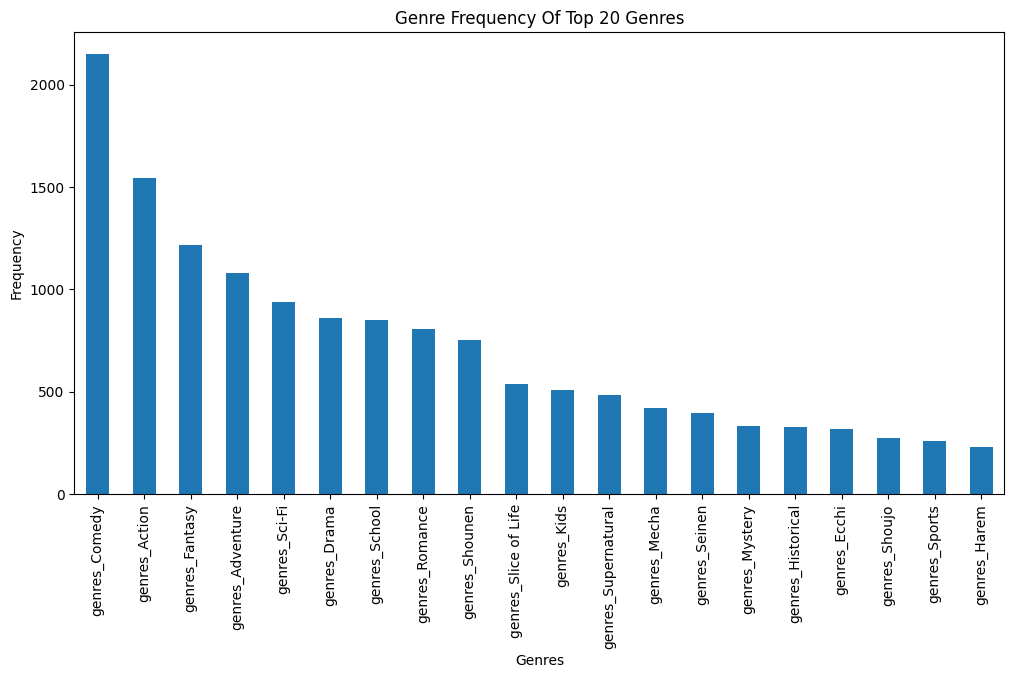

In [ ]:
# Calculate the sum of each genre column
genre_counts = combined_df.iloc[:, 10:86].sum()

# Plot the genre frequencies
plt.figure(figsize=(12, 6))
genre_counts.sort_values(ascending=False).iloc[:20].plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Genre Frequency Of Top 20 Genres')
plt.xticks(rotation=90)
plt.show()


## Feature engineering and Model building

In [ ]:
# Read the anime data from the CSV file
data = pd.read_csv('anime.csv')
data = data[['id','title', 'genres', 'media_type', 'num_episodes','studios','rank']]
data.sort_values('rank',ascending=True,inplace=True)
len(data)

# Clean the genres column by removing unwanted characters
data['genres'] = data['genres'].apply(lambda x: x.strip('[]').replace("'", "").replace(', ',' '))

# Keep a copy of the DataFrame with only 'tv' media_type
data = data.loc[data['media_type'] == 'tv'].copy()

# Define a clean function to preprocess text data
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data["cleaned_Title"] = data["title"].apply(clean)
data["cleaned_Genre"] = data["genres"].apply(clean)
data["cleaned_Studio"] = data["studios"].apply(clean)
data["cleaned_TitleGenre"] = data["cleaned_Title"] + " " + data["cleaned_Genre"]+ " " + data["cleaned_Studio"]

# Create a Series with indices based on cleaned_TitleGenre
indices = pd.Series(data.index,index=data['cleaned_TitleGenre']).drop_duplicates()

# Function to calculate similarity scores
def get_similarity(title):
    new_title = False
    feature = data["cleaned_TitleGenre"].tolist()
    if not(title in feature):
        new_title = True
        feature.append(title)

    tfidf = text.TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(feature)
    similarity = cosine_similarity(tfidf_matrix)
    del tfidf
    del tfidf_matrix

    if (new_title):
        del feature
        return similarity[len(similarity) - 1]
    else:
        del feature
        index = pd.Series(indices[title])
        return similarity[index[0]]

# Function to recommend anime based on title and genre
def Anime_Recommendation(ID, title, genre, studio):
    cleaned_title = clean(title)
    cleaned_genre = clean(genre)
    cleaned_TitleGenre = cleaned_title + " " + cleaned_genre

    similarity = get_similarity(cleaned_TitleGenre)
    similarity_scores = list(enumerate(similarity))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = filter(lambda x: x[1] > 0, similarity_scores)
    similarity_scores = list(similarity_scores)

    movieindices = [i[0] for i in similarity_scores if i[0] < len(data)]
    scores = [i[1] for i in similarity_scores if i[0] < len(data)]
    result = pd.DataFrame([data.iloc[i] for i in movieindices])
    result['score'] = scores
    result = result[result["id"] != ID]
    result = result[['id', 'title', 'genres', 'media_type','studios', 'num_episodes', 'score']]

    print('\n','-'*100)
    print("Anime Recommendation: ", title)
    print("Title:", title)
    print("Genre:", genre)
    print("Studio:",studio)
    print("Anime Recommendation:")

    pd.set_option('display.max_colwidth',None)
    result.reset_index(drop=True,inplace=True)
    result.index = result.index + 1
    display(result.head(10))

    del similarity
    del similarity_scores
    del movieindices
    del scores

# Function to recommend anime based on input
def Anime(inp):
    anime = data.loc[data["title"] == clean(inp)]
    if anime.empty:
        anime = data[data["title"].str.contains(clean(inp), case=False)]
        if anime.empty:
          print('\n','-'*100)
          print("No anime found for the given anime input.")
          return

        ID = anime.iloc[0]["id"]
        title = anime.iloc[0]["title"].lower()
        genre = anime.iloc[0]["genres"].lower()
        studio = anime.iloc[0]["studios"].lower()
        Anime_Recommendation(ID, title, genre,studio)
        return

    ID = anime.iloc[0]["id"]
    title = anime.iloc[0]["title"].lower()
    genre = anime.iloc[0]["genres"].lower()
    studio = anime.iloc[0]["studios"].lower()
    Anime_Recommendation(ID, title, genre,studio)

# Function to recommend anime based on genre
def genre(inp):
    input_genre = clean(inp)
    result = data[data["genres"].apply(lambda x: input_genre in x.lower().split())]

    result = result[['id', 'title', 'genres', 'media_type','studios', 'num_episodes']]
    pd.set_option('display.max_colwidth',None)
    result.reset_index(drop=True,inplace=True)
    result.index = result.index + 1

    if result.empty:
      print('\n','-'*100)
      print("No anime found for the given genre input.")
      return

    print('\n','-'*100)
    print("Genre:", inp)
    print("Anime Recommendation:")
    display(result.head(10))

# Testing the functions
Anime('Naruto')
Anime('code geass')
Anime('one piece')
Anime("Classroom of the ")

genre('romance')
genre('school')
genre("Action")
genre('kashi')


 ----------------------------------------------------------------------------------------------------
Anime Recommendation:  naruto
Title: naruto
Genre: action adventure fantasy martial arts shounen
Studio: pierrot
Anime Recommendation:


,id,title,genres,media_type,studios,num_episodes,score
1,1735,naruto: shippuuden,Action Adventure Fantasy Martial Arts Shounen,tv,pierrot,500,0.740693
2,54688,naruto (shinsaku anime),Action Adventure Fantasy Martial Arts Shounen,tv,NaN,4,0.706249
3,34566,boruto: naruto next generations,Action Adventure Fantasy Martial Arts Shounen,tv,pierrot,293,0.600481
4,54687,boruto: naruto next generations part 2,Action Adventure Fantasy Martial Arts Shounen,tv,NaN,0,0.586190
5,6056,sasuke,Action Historical Martial Arts Shounen,tv,NaN,29,0.421070
6,813,dragon ball z,Action Adventure Comedy Fantasy Martial Arts Shounen Super Power,tv,toei animation,291,0.403528
7,223,dragon ball,Action Adventure Comedy Fantasy Martial Arts Shounen Super Power,tv,toei animation,153,0.403528
8,36015,shaolin chuanqi,Action Adventure Comedy Fantasy Martial Arts,tv,NaN,26,0.400439
9,22547,blade & soul,Action Adventure Fantasy Martial Arts,tv,gonzo,13,0.380093
10,4427,tatakae!! ramenman,Action Adventure Martial Arts Shounen,tv,toei animation,35,0.371548



 ----------------------------------------------------------------------------------------------------
Anime Recommendation:  code geass: hangyaku no lelouch r2
Title: code geass: hangyaku no lelouch r2
Genre: action award winning drama mecha military sci-fi super power
Studio: sunrise
Anime Recommendation:


,id,title,genres,media_type,studios,num_episodes,score
1,1575,code geass: hangyaku no lelouch,Action Award Winning Drama Mecha Military School Sci-Fi Super Power,tv,sunrise,25,0.966728
2,32360,qualidea code,Action Fantasy Sci-Fi Super Power,tv,a-1 pictures,12,0.349255
3,95,turn a gundam,Action Adventure Award Winning Drama Mecha Military Romance Sci-Fi Space,tv,sunrise,50,0.345080
4,3572,macross f,Action Award Winning Mecha Military Music Romance Sci-Fi Space,tv,satelight,25,0.334782
5,593,mugen no ryvius,Award Winning Drama Mecha Military Psychological Sci-Fi Space,tv,sunrise,26,0.327482
6,93,kidou senshi gundam seed,Action Award Winning Drama Mecha Military Romance Sci-Fi Space,tv,sunrise,50,0.308065
7,41457,86,Action Drama Mecha Military Sci-Fi,tv,a-1 pictures,11,0.305827
8,35847,ssss.gridman,Action Award Winning Mecha Sci-Fi,tv,trigger,12,0.298165
9,165,rahxephon,Action Award Winning Drama Mecha Music Mystery Psychological Romance Sci-Fi,tv,bones,26,0.293314
10,48849,sonny boy,Award Winning Isekai Mystery Super Power,tv,madhouse,12,0.287141



 ----------------------------------------------------------------------------------------------------
Anime Recommendation:  one piece
Title: one piece
Genre: action adventure fantasy shounen
Studio: toei animation
Anime Recommendation:


,id,title,genres,media_type,studios,num_episodes,score
1,54856,horimiya: piece,Romance School Shounen,tv,cloverworks,13,0.431874
2,1667,barom one,Action Sci-Fi Shounen Supernatural,tv,e&g films,13,0.347583
3,52807,one punch man 3,Action Adult Cast Comedy Parody Seinen Super Power,tv,NaN,0,0.286737
4,30276,one punch man,Action Adult Cast Comedy Parody Seinen Super Power,tv,madhouse,12,0.277539
5,51458,lv1 maou to one room yuusha,Comedy Fantasy,tv,silver link.,0,0.275579
6,34134,one punch man 2nd season,Action Adult Cast Comedy Parody Seinen Super Power,tv,j.c.staff,12,0.271267
7,36431,one room: second season,Slice of Life,tv,zero-g,12,0.270200
8,34392,one room,Slice of Life,tv,typhoon graphics,12,0.266083
9,41364,one room: third season,Slice of Life,tv,zero-g,12,0.261377
10,38331,stand my heroes: piece of truth,Mystery Reverse Harem Romance Shoujo,tv,m.s.c,12,0.246471



 ----------------------------------------------------------------------------------------------------
No anime found for the given anime input.

 ----------------------------------------------------------------------------------------------------
Genre: romance
Anime Recommendation:


,id,title,genres,media_type,studios,num_episodes
1,43608,kaguya-sama wa kokurasetai: ultra romantic,Comedy Romance School Seinen,tv,a-1 pictures,13
2,42938,fruits basket: the final,Drama Romance Shoujo Supernatural,tv,tms entertainment,13
3,4181,clannad: after story,Drama Romance Supernatural,tv,kyoto animation,24
4,17074,monogatari series: second season,Comedy Mystery Romance Supernatural Vampire,tv,shaft,26
5,23273,shigatsu wa kimi no uso,Drama Love Polygon Music Romance School Shounen,tv,a-1 pictures,22
6,7785,yojouhan shinwa taikei,Award Winning Comedy Mystery Psychological Romance Time Travel,tv,madhouse,11
7,40417,fruits basket 2nd season,Drama Romance School Shoujo Supernatural,tv,tms entertainment,25
8,877,nana,Adult Cast Drama Love Polygon Music Romance Shoujo,tv,madhouse,47
9,12365,bakuman. 3rd season,Comedy Drama Otaku Culture Romance Shounen,tv,j.c.staff,25
10,38889,kono oto tomare! part 2,Drama Music Performing Arts Romance School Shounen,tv,platinum vision,13



 ----------------------------------------------------------------------------------------------------
Genre: school
Anime Recommendation:


,id,title,genres,media_type,studios,num_episodes
1,43608,kaguya-sama wa kokurasetai: ultra romantic,Comedy Romance School Seinen,tv,a-1 pictures,13
2,32935,haikyuu!! karasuno koukou vs. shiratorizawa gakuen koukou,School Shounen Sports Team Sports,tv,production i.g,10
3,1575,code geass: hangyaku no lelouch,Action Award Winning Drama Mecha Military School Sci-Fi Super Power,tv,sunrise,25
4,245,great teacher onizuka,Comedy Delinquents School Shounen Workplace,tv,pierrot,43
5,23273,shigatsu wa kimi no uso,Drama Love Polygon Music Romance School Shounen,tv,a-1 pictures,22
6,40748,jujutsu kaisen,Action Award Winning Fantasy School Shounen,tv,mappa,24
7,40591,kaguya-sama wa kokurasetai? tensai-tachi no renai zunousen,Comedy Psychological Romantic Subtext School Seinen,tv,a-1 pictures,12
8,28891,haikyuu!! second season,School Shounen Sports Team Sports,tv,production i.g,25
9,40417,fruits basket 2nd season,Drama Romance School Shoujo Supernatural,tv,tms entertainment,25
10,40776,haikyuu!! to the top part 2,School Shounen Sports Team Sports,tv,production i.g,12



 ----------------------------------------------------------------------------------------------------
Genre: Action
Anime Recommendation:


,id,title,genres,media_type,studios,num_episodes
1,5114,fullmetal alchemist: brotherhood,Action Adventure Drama Fantasy Military Shounen,tv,bones,64
2,41467,bleach: sennen kessen-hen,Action Adventure Fantasy Shounen,tv,pierrot,13
3,38524,shingeki no kyojin season 3 part 2,Action Drama Gore Military Shounen Survival,tv,wit studio,10
4,28977,gintama°,Action Comedy Gag Humor Historical Parody Samurai Sci-Fi Shounen,tv,bandai namco pictures,51
5,9969,gintama',Action Comedy Gag Humor Historical Parody Samurai Sci-Fi Shounen,tv,sunrise,51
6,11061,hunter x hunter (2011),Action Adventure Fantasy Shounen,tv,madhouse,148
7,15417,gintama': enchousen,Action Comedy Gag Humor Historical Parody Samurai Sci-Fi Shounen,tv,sunrise,13
8,34096,gintama.,Action Comedy Gag Humor Historical Parody Samurai Sci-Fi Shounen,tv,bandai namco pictures,12
9,918,gintama,Action Comedy Gag Humor Historical Parody Samurai Sci-Fi Shounen,tv,sunrise,201
10,2904,code geass: hangyaku no lelouch r2,Action Award Winning Drama Mecha Military Sci-Fi Super Power,tv,sunrise,25



 ----------------------------------------------------------------------------------------------------
No anime found for the given genre input.
